In [1]:
from model import NNCLR

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

/Users/z5214005/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
model_version = '3-31'
input_shape = (224,224,1)
temperature = 0.1
queue_size = 1000
batch_size = 16

stddev = 0.017359

In [3]:
# Load the saved model
model = NNCLR(input_shape=input_shape,
              temperature=temperature,
              queue_size=queue_size)

model.compile(
    contrastive_optimizer=keras.optimizers.Adam()
)

model.load_weights(f'checkpoint-{model_version}/checkpoint.ckpt').expect_partial()

In [4]:
def preprocess(data):
    image = data['image']
    image = tf.clip_by_value(image, 0.0, 10.0)
    image = tf.math.asinh(image / stddev)
    return image

initial_dataset = tfds.load('hsc_icl', split='train')
dataset = initial_dataset.map(preprocess).batch(batch_size)

# Turn the dataset into a list so that we can index it
ds_list = list(dataset.unbatch().as_numpy_iterator())

In [5]:
# Get embeddings
embeddings = model.predict(dataset, batch_size=batch_size)
embeddings.shape

149/149 [==============================] - 514s 3s/step


(2377, 256)

In [6]:
@tf.function
def compute_similarity(p, z):
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return tf.reduce_sum((p * z), axis=1)

In [7]:
# Generate a query encoding and compute similarity to dataset embeddings
query = np.expand_dims(ds_list[0], 0) # Query image
z = model.encoder(query)

similarities = compute_similarity(embeddings, z)
similarities

<tf.Tensor: shape=(2377,), dtype=float32, numpy=
array([0.9999999 , 0.6503451 , 0.35400498, ..., 0.29532415, 0.95063746,
       0.62533087], dtype=float32)>

In [10]:
# Rank the similarities in descending order and get corresponding indices
ranking = np.argsort(similarities)[::-1]
if similarities[ranking[0]] > 1. - 1e-6:
    # Don't include query image in the results
    ranking = ranking[1:]
ranking

array([1926,  397,  289, ...,  917, 2317, 1139])

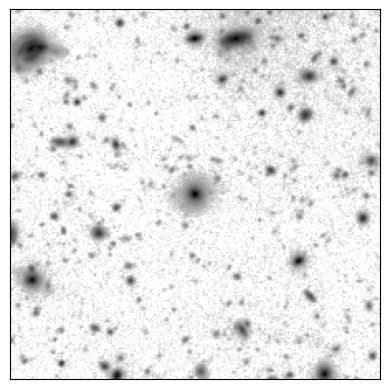

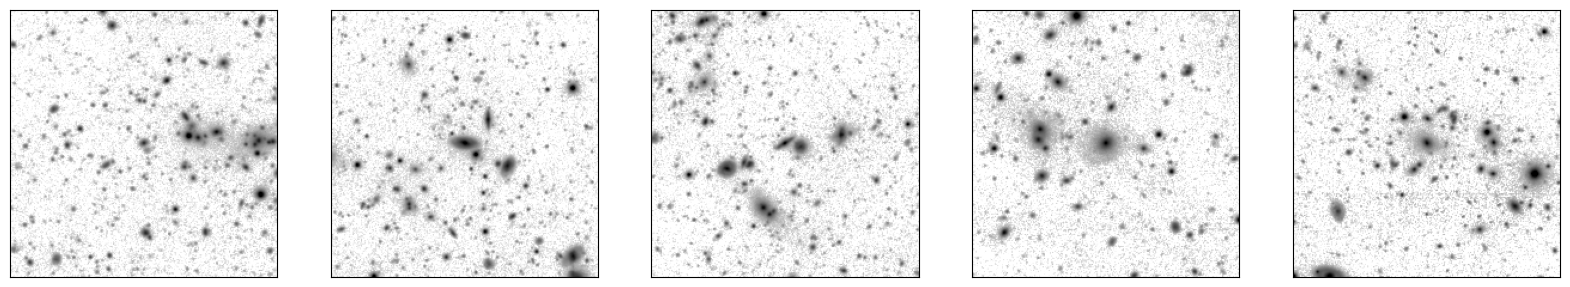

In [11]:
# Plot the query image and the top 5 most similar images
plt.imshow(query.squeeze(), origin='lower', cmap='gray_r')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(ds_list[ranking[i]], cmap='gray_r')
plt.show()

In [12]:
# Open the cutouts.hdf file so that we can query with known clusters using
# indices from the catalogue
import h5py

cutouts = h5py.File('data/processed/cutouts.hdf')

In [13]:
import skimage
def create_img(cutout, target_size=224):
    """
    Convenience function to take in the fits cutout file and return an image 
    with the correct size
    """
    # Retrieve image data
    img = np.array(cutout['HDU0']['DATA'])

    # Resize image to desired cutout size
    resized = skimage.transform.resize(img, (target_size, target_size))

    resized = np.expand_dims(resized, axis=2)

    return resized

In [14]:
def show_similar(idx):
    """
    Function to take in an index, query the set of images and display the top
    5 most similar
    """
    # Generate a query encoding and compute similarity to dataset embeddings
    query = {'image': create_img(cutouts[str(idx)])} # dict for preprocessing
    query = preprocess(query)
    query = np.expand_dims(query, 0) # Fix shape for encoder
    z = model.encoder(query)
    similarities = compute_similarity(embeddings, z)

    # Rank the similarities in descending order and get corresponding indices
    ranking = np.argsort(similarities)[::-1]
    if similarities[ranking[0]] >= 1. - 1e-6: # equal to 1 within tolerance
        # Don't include the query image in the results
        ranking = ranking[1:]
    
    # Plot the query image and the top 5 most similar images
    plt.imshow(query.squeeze(), origin='lower', cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    plt.figure(figsize=(20,4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(ds_list[ranking[i]], cmap='gray_r', origin='lower')
    plt.show()

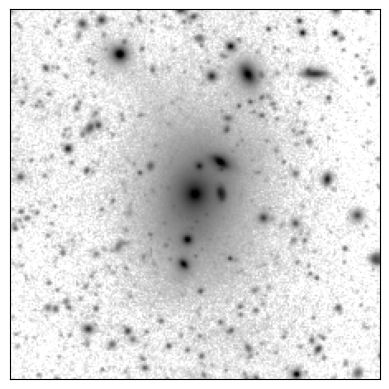

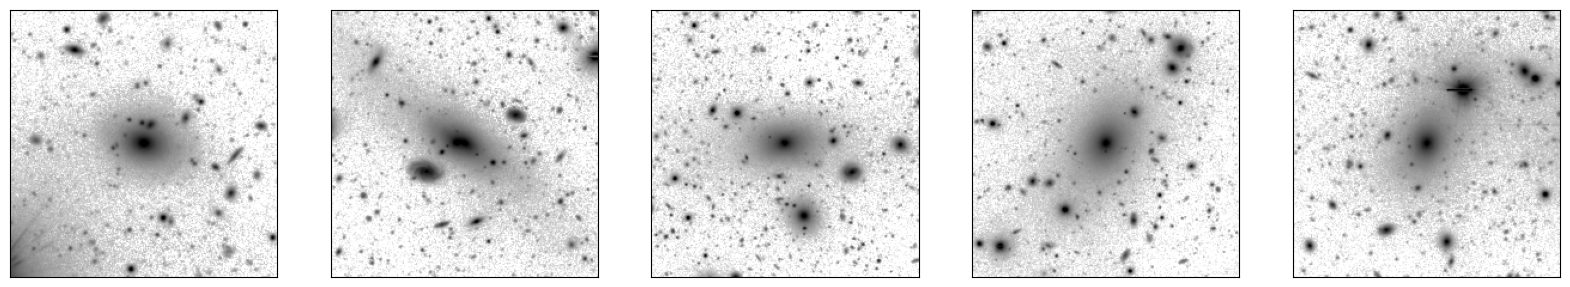

In [15]:
show_similar(18)

In [17]:
# The cluster with highest listed ICL fraction is cluster 18
# Try ranking all other clusters according to similarity to this one
query = {'image': create_img(cutouts['18'])}
query = preprocess(query)
query = np.expand_dims(query, 0)
z = model.encoder(query)
similarities = compute_similarity(embeddings, z)

# Rank the similarities in descending order and get corresponding indices
ranking = np.argsort(similarities)[::-1]
if similarities[ranking[0]] >= 1. - 1e-6:
    ranking = ranking[1:]
ranking

array([1519,  823, 1949, ..., 2327,  595,  701])

In [18]:
# What ranks do all the other studied ICL clusters have
studied_ids = [17, 14, 2317, 39, 45, 967, 73]

# These ids do not correspond to dataset indices :/ -> pass through encoder and
# use similarity of embeddings to find these clusters (or could do something to
# figure out and map dataset indices to catalogue indices)
imgs = []
for i in studied_ids:
    imgs.append({'image': create_img(cutouts[str(i)])})

query = list(map(preprocess, imgs))
query = np.array(query)
zs = model.encoder(query) # Put all images through encoder

In [19]:
# Find the corresponding dataset indices
ds_ids = []

for i in range(zs.shape[0]):
    similarities = compute_similarity(embeddings, np.expand_dims(zs[i], 0))
    highest = np.argsort(similarities)[-1]
    ds_ids.append(highest)

In [20]:
# Find similarity ranks of all other studied clusters
for i in studied_ids:
    print(np.where(ranking == i)[0][0])

1592
2341
2147
53
2226
207
869
